## About
This notebook is used to compute the best aligned rosetta pose from TM output.<br/>
This pose can later be used for other analyses

**Note:** Some parts of this code may be sensitive to the RNA chosen. These regions are marked out with a <i>'#TODO: Change accordingly'</i> tag

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
%run ../PyRosetta/General.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org


In [2]:
ROOT_DIR="/home/venkata/python/PyRosetta/R1107/server/example5/" #TODO: Change Accordingly
print("Rosetta folder found:",("rosetta" in os.listdir(ROOT_DIR)))

Rosetta folder found: True


In [3]:
in_file=ROOT_DIR+"/rosetta/combined.out"
ref_pose=LoadedPDB(ROOT_DIR+"../../7qr4_clean_noprotein.pdb") #TODO: Change Accordingly (Set it to the path of your crystal PDB)
poses=[pose for pose in poses_from_silent(in_file)]
print(len(poses),"rosetta structures loaded.")

416 rosetta structures loaded.


### Sanity check
Making sure that all the hydrogen and non-hydrogen atoms align (i.e. all atoms correspond 1-1)

In [4]:
for rid,resid in enumerate(ref_pose):
    for i,atom in enumerate(resid.atoms()):
        chk1=resid.atom_is_hydrogen(i+1)
        chk2=poses[0].residue(rid+1).atom_is_hydrogen(i+1)
        if chk1!=chk2:
            print("ERR:\t",end="")
            print(rid,i)
else:
    print("All good")

All good


In [5]:
resolved_rmsds=[]
for i in range(len(poses)):
    print("Rosetta Structure:",i)
    aligned_pose=align_poses(ref_pose,poses[i],silent=True)
    print("\tPrevious RMSD:",get_rmsd(ref_pose,poses[i]))
    final_rmsd=get_rmsd(ref_pose,aligned_pose)
    print("\tFinal RMSD:",final_rmsd)
    #aligned_pose.dump_pdb("R1107/server/R1107_long_rosetta_"+str(i)+"_relaxed_aligned_noH.pdb") # TODO: Change accordingly (Uncomment to dump an aligned PDB file)
    resolved_rmsds.append(final_rmsd)
resolved_rmsds=np.array(resolved_rmsds)

Rosetta Structure: 0
	Previous RMSD: 1.3098542080238584
	Final RMSD: 0.21927712371372618
Rosetta Structure: 1
	Previous RMSD: 0.006179402640377199
	Final RMSD: 0.0061766335899138885
Rosetta Structure: 2
	Previous RMSD: 0.01916240523270379
	Final RMSD: 0.019153371439502187
Rosetta Structure: 3


KeyboardInterrupt: 

In [6]:
# Save the RMSDs
np.save(ROOT_DIR+"/rosetta/RMSD_crystal.npy",resolved_rmsds)

# Print out the lowest RMSD
print("Lowest RMSD:",np.min(resolved_rmsds))

Lowest RMSD: nan


In [9]:
resolved_rmsds=np.load(ROOT_DIR+"/rosetta/RMSD_crystal.npy")

(array([1]), [])

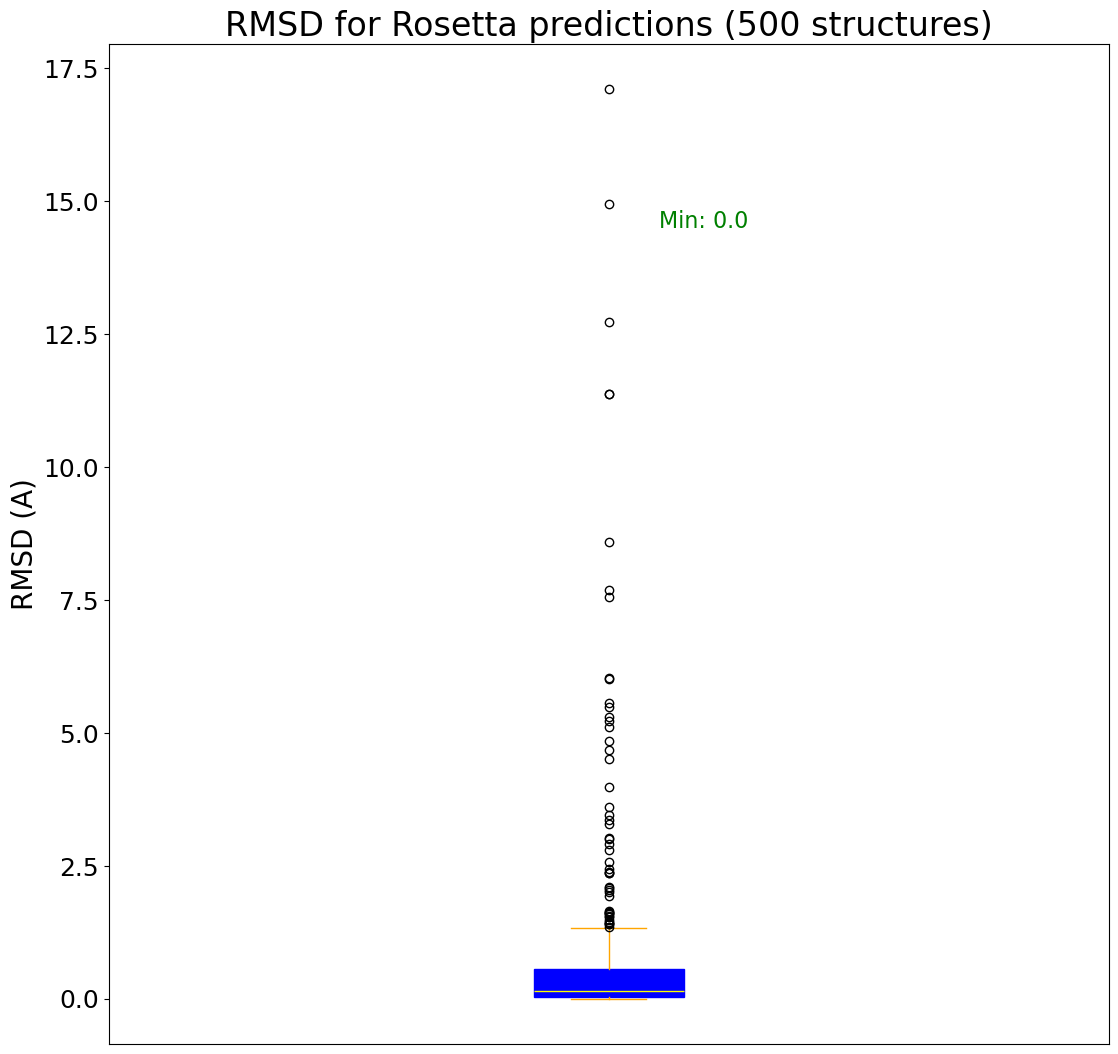

In [12]:
# Make a box-plot with rosetta poses RMSD values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax = plt.axes((0, 0, 1, 1))
ax.text(1.05,14.5, "Min: "+str(round(np.min(resolved_rmsds),2)), fontsize=16, color='green')
bplot=plt.boxplot(resolved_rmsds,patch_artist=True,notch=False)
bplot["boxes"][0].set_color("blue")
bplot["medians"][0].set_color("yellow")
[whisk.set_color("orange") for whisk in bplot["whiskers"]]
[whisk.set_color("orange") for whisk in bplot["caps"]]

plt.title("RMSD for Rosetta predictions (500 structures)",fontsize=24)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.yticks(fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.xticks()
#plt.ylim(0,2)

#### Save the pose closest to the crystal structure

In [13]:
best_rosetta=poses[np.argmin(resolved_rmsds)]

# Align the closest match to the crystal structure and save it
aligned_best_rosetta=align_poses(ref_pose,best_rosetta,silent=True,max_iter=5000)
aligned_best_rosetta.dump_pdb(ROOT_DIR+"/rosetta/crystal_closest.pdb")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn